<a href="https://colab.research.google.com/github/WillianRullian/SIVIDA/blob/main/sividaneuralmodel_1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bibliotecas de manipulação de dados
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Bibliotecas para redes neurais (Keras/TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Bibliotecas adicionais
import random


In [ ]:

class EnvironmentalMonitor:
    def __init__(self, db_name="environment_data.db"):
        """Inicializa o monitor de ambiente, configurando o banco de dados."""
        self.db_name = db_name
        self.create_or_update_table()

    def create_or_update_table(self):
        """Cria ou atualiza a tabela 'environment' no banco de dados."""
        connection = sqlite3.connect(self.db_name)
        cursor = connection.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS environment (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TEXT NOT NULL,
                temperature REAL,
                humidity REAL,
                co2 REAL,
                tvoc REAL,
                air_quality TEXT
            )
        """)
        connection.commit()
        connection.close()

    def read_sensors(self):
        """Simula a leitura dos sensores com dados realistas."""
        temperature = random.uniform(18.0, 30.0)  # Temperatura realista
        humidity = random.uniform(40.0, 80.0)    # Umidade realista
        co2 = random.uniform(400, 500)            # CO2 em ppm realista
        tvoc = random.uniform(0, 1.5)             # TVOC em mg/m³ realista

        # Definir qualidade do ar com base na temperatura e umidade
        if temperature < 25 and humidity > 50:
            air_quality = "Bom"
        elif temperature >= 25 and humidity < 50:
            air_quality = "Ruim"
        else:
            air_quality = "Bom"

        return {
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "temperature": round(temperature, 2),
            "humidity": round(humidity, 2),
            "co2": round(co2, 2),
            "tvoc": round(tvoc, 2),
            "air_quality": air_quality
        }

    def save_to_database(self, data):
        """Salva os dados coletados no banco de dados."""
        connection = sqlite3.connect(self.db_name)
        cursor = connection.cursor()
        cursor.execute("""
            INSERT INTO environment (timestamp, temperature, humidity, co2, tvoc, air_quality)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (data['timestamp'], data['temperature'], data['humidity'], data['co2'], data['tvoc'], data['air_quality']))
        connection.commit()
        connection.close()

    def get_data_as_dataframe(self):
        """Recupera os dados do banco de dados como um DataFrame."""
        connection = sqlite3.connect(self.db_name)
        query = "SELECT * FROM environment"
        df = pd.read_sql_query(query, connection)
        connection.close()
        return df

    def collect_multiple_samples(self, num_samples=100):
        """Coleta múltiplas amostras e as armazena no banco de dados."""
        for _ in range(num_samples):
            data = self.read_sensors()
            if data:
                self.save_to_database(data)

    def clear_database(self):
        """Limpa todos os dados do banco de dados."""
        connection = sqlite3.connect(self.db_name)
        cursor = connection.cursor()
        cursor.execute("DELETE FROM environment")
        connection.commit()
        connection.close()

# Testando a classe
monitor = EnvironmentalMonitor()
monitor.clear_database()  # Limpar dados antigos, se necessário
monitor.collect_multiple_samples(num_samples=1000)  # Coletar novas amostras
df = monitor.get_data_as_dataframe()
print(f"Total de amostras coletadas: {len(df)}")
print(df.head())  # Verificar as primeiras amostras para garantir que estão no formato esperado



Total de amostras coletadas: 1000
      id            timestamp  temperature  humidity air_quality     co2  tvoc
0  37102  2024-11-25 01:19:36        22.49     49.96         Bom  434.79  1.07
1  37103  2024-11-25 01:19:36        21.60     55.22         Bom  477.73  0.10
2  37104  2024-11-25 01:19:36        19.52     41.67         Bom  438.02  0.61
3  37105  2024-11-25 01:19:36        28.43     70.03         Bom  494.97  1.09
4  37106  2024-11-25 01:19:36        18.43     77.96         Bom  447.66  1.22


In [ ]:
def remove_outliers_iqr(dataframe, columns, threshold=1.5):
    """
    Remove outliers de um DataFrame com base no método IQR.

    Parâmetros:
        dataframe (pd.DataFrame): O DataFrame original.
        columns (list): Lista de colunas a serem analisadas para remoção de outliers.
        threshold (float): Multiplicador do IQR para definir limites (default: 1.5).

    Retorna:
        pd.DataFrame: DataFrame sem os outliers.
    """
    df_cleaned = dataframe.copy()

    for column in columns:
        Q1 = dataframe[column].quantile(0.25)  # Primeiro quartil (25%)
        Q3 = dataframe[column].quantile(0.75)  # Terceiro quartil (75%)
        IQR = Q3 - Q1  # Intervalo Interquartil

        # Limites inferior e superior
        lower_limit = Q1 - threshold * IQR
        upper_limit = Q3 + threshold * IQR

        # Filtrar os dados dentro dos limites
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_limit) & (df_cleaned[column] <= upper_limit)]

    return df_cleaned


In [ ]:
# Colunas que queremos verificar para outliers
columns_to_clean = ['temperature', 'humidity', 'co2', 'tvoc']

# Aplicar a função para remover outliers
df_cleaned = remove_outliers_iqr(df, columns_to_clean)

# Comparar antes e depois
print(f"Quantidade de registros antes da limpeza: {df.shape[0]}")
print(f"Quantidade de registros depois da limpeza: {df_cleaned.shape[0]}")


Quantidade de registros antes da limpeza: 1000
Quantidade de registros depois da limpeza: 1000


In [ ]:
# Converter a qualidade do ar para numérico
df['air_quality'] = df['air_quality'].map({"Bom": 1, "Ruim": 0})

# Selecionar features e target
features = ['temperature', 'humidity', 'co2', 'tvoc']
target = 'air_quality'

# Dividir em entrada (X) e saída (y)
X = df[features]
y = df[target]



In [ ]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Redimensionar para formato 3D
time_steps = 5
X_scaled = np.array([X_scaled[i:i+time_steps] for i in range(len(X_scaled) - time_steps)])
y = np.array(y[time_steps:])

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Cálculo de pesos para classes desbalanceadas
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Construção do modelo LSTM para Regressão/Classe
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Usar Input(shape) para a primeira camada
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))  # Aumentar dropout
model.add(LSTM(units=32, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu', kernel_regularizer='l2'))  # Adicionar regularização L2
model.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5160 - loss: 0.9763 - val_accuracy: 0.5327 - val_loss: 1.0145
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5342 - loss: 1.0414 - val_accuracy: 0.5176 - val_loss: 1.0008
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5128 - loss: 1.0266 - val_accuracy: 0.5327 - val_loss: 0.9871
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5459 - loss: 0.9614 - val_accuracy: 0.5377 - val_loss: 0.9736
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5235 - loss: 1.0216 - val_accuracy: 0.4774 - val_loss: 0.9625
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4895 - loss: 1.0595 - val_accuracy: 0.4874 - val_loss: 0.9508
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5433 - loss: 0.9517 - val_accuracy: 0.5980 - val_loss: 0.9375
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5602 - loss: 0.8707 - val_accuracy: 0.6030 - va

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6046 - loss: 0.7035 
Loss: 0.693646252155304
Accuracy: 0.623115599155426


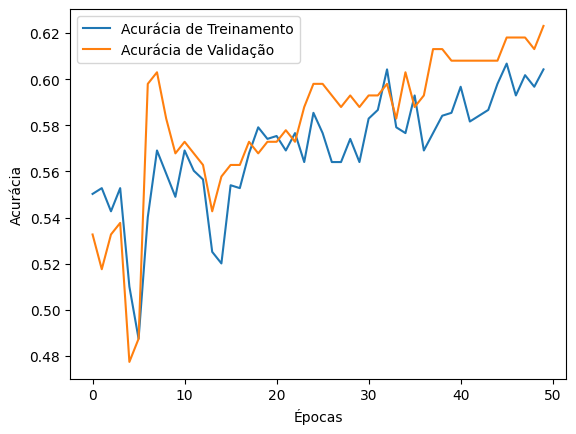

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step


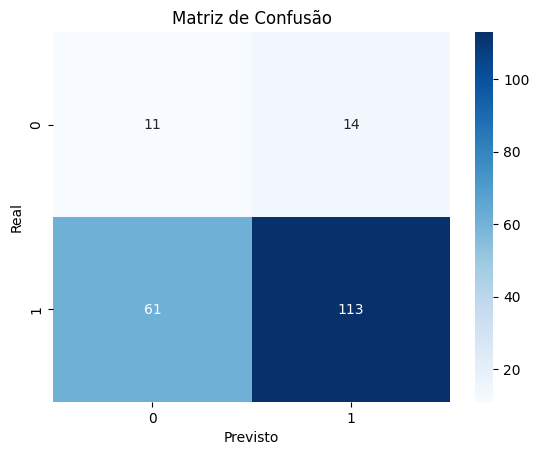

              precision    recall  f1-score   support

           0       0.15      0.44      0.23        25
           1       0.89      0.65      0.75       174

    accuracy                           0.62       199
   macro avg       0.52      0.54      0.49       199
weighted avg       0.80      0.62      0.68       199

AUC-ROC: 0.5447


In [ ]:
# Avaliação
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Curvas de aprendizado
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Matriz de confusão
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# Relatório de classificação
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")
